In [2]:
import sys
sys.path.append('/home/niklas/projects/style_transfer')
from oads_access.oads_access import OADS_Access

In [10]:
basedir = '/home/niklas/projects/data/oads/'
oads = OADS_Access(basedir=basedir, min_size_crops=(400, 400), max_size_crops=(400,400))

In [12]:
img, lbl = oads.load_crop_from_image(image_name=list(oads.image_names.keys())[0], index=0)

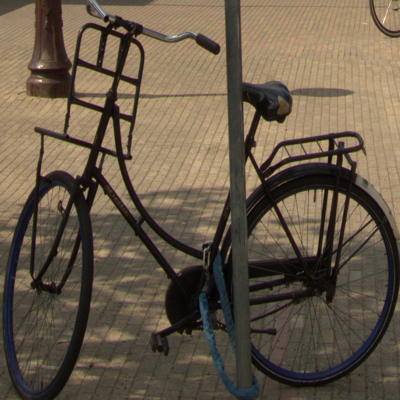

In [13]:
img

e16162bab3b29c9c


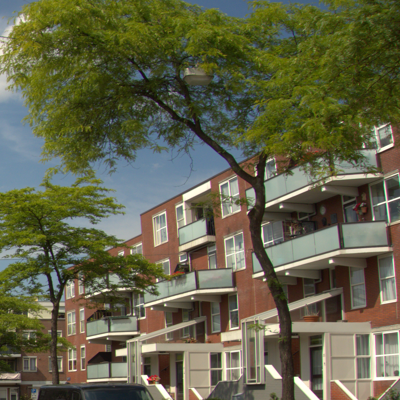

In [32]:
img_name, index = oads.images_per_class['Tree'][0].split('_')
print(img_name)
texture, _ = oads.load_crop_from_image(image_name=str(img_name), index=int(index))
texture

# Stylize

In [34]:
from datetime import datetime

import numpy as np
# import tensorflow as tf
# from tensorflow.contrib.opt import ScipyOptimizerInterface

from style_transfer import StyleTransfer
import utils


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:


#############
## OPTIONS ##
#############

# image paths
# styl_path = './images/style/starry_night.jpg'
# cont_path = './images/content/tubingen.jpg'
folder = "./gen_img/"

# hyper-parameters
# img_shape = utils.optimal_dimension(cont_path, square=False) 	# [batch, width, height, channels]
img_shape = [1, 400, 400, 3]
alpha = 1e-6                    								# content weight alpha
beta = 1                        								# style weight beta
num_steps = 1000               									# training iterations
save_per_step = 100              								# save image per this number of step


In [ ]:

# content and style layers used in style transfer
cont_layers = ["relu4_2"] # for matlab vgg
styl_layers = ["relu1_1", "relu2_1", "relu3_1", "relu4_1", "relu5_1"]


# weights on each style layer
styl_weights = {"relu1_1": 0.2, "relu1_2": 0.2, "pool1": 0,
                "relu2_1": 0.2, "relu2_2": 0.2, "pool2": 0,
                "relu3_1": 0.2, "relu3_2": 0.2, "relu3_3": 0.2, "relu3_4": 0, "pool3": 0,
                "relu4_1": 0.2, "relu4_2": 0.2, "relu4_3": 0.2, "relu4_4": 0, "pool4": 0,
                "relu5_1": 0.2, "relu5_2": 0.2, "relu5_3": 0.2, "relu5_4": 0, "pool5": 0}

# weights on each style layer
cont_weights = {"relu1_1": 1, "relu1_2": 0.2, "pool1": 0,
                "relu2_1": 1, "relu2_2": 0, "pool2": 0,
                "relu3_1": 1, "relu3_2": 0, "relu3_3": 0.2, "relu3_4": 0, "pool3": 0,
                "relu4_1": 1, "relu4_2": 1, "relu4_3": 0.2, "relu4_4": 0, "pool4": 0,
                "relu5_1": 1, "relu5_2": 0, "relu5_3": 0.2, "relu5_4": 0, "pool5": 0}




In [ ]:

################
## PREPROCESS ##
################


# cont_img = utils.load_image(cont_path, img_shape)
# styl_img = utils.load_image(styl_path, img_shape)
cont_img = img
styl_img = texture
init_img = utils.load_init_image(cont_img, styl_img, img_shape, choice="rand_uni")

cont_img = utils.img_preprocess(cont_img)
styl_img = utils.img_preprocess(styl_img)
init_img = utils.img_preprocess(init_img)


In [ ]:

model = StyleTransfer(init_img,
                      cont_img,
                      styl_img,
                      cont_layers,
                      styl_layers,
                      cont_weights,
                      styl_weights,
                      alpha,
                      beta)

##############
## TRAINING ##
##############

with tf.Session(graph=model.graph) as sess:
    sess.run(tf.global_variables_initializer())

    optimizer = ScipyOptimizerInterface(model.total_loss, method="L-BFGS-B", options={'maxiter': num_steps})
    optimizer.minimize(sess,
                       fetches=[model.styl_loss, model.cont_loss, model.total_loss,
                                model.styl_loss_list, model.cont_loss_list,
                                model.gen_cont_act, model.gen_styl_act,
                                model.styl_act, model.cont_act,
                                model.image],
                       step_callback=model.step_callback(img_shape, save_per_step),
                       loss_callback=model.loss_callback())

    result_array = sess.run(model.image)
    result_array = utils.img_postprocess(result_array)
    utils.save_image(folder, result_array)
print("Style Transfer Complete.")
